In [2]:
from vlm_drive.simulation.carla_sim import CarlaSim

carla_sim = CarlaSim()


Starting navigation

Driving...
Waypoint has been reached.


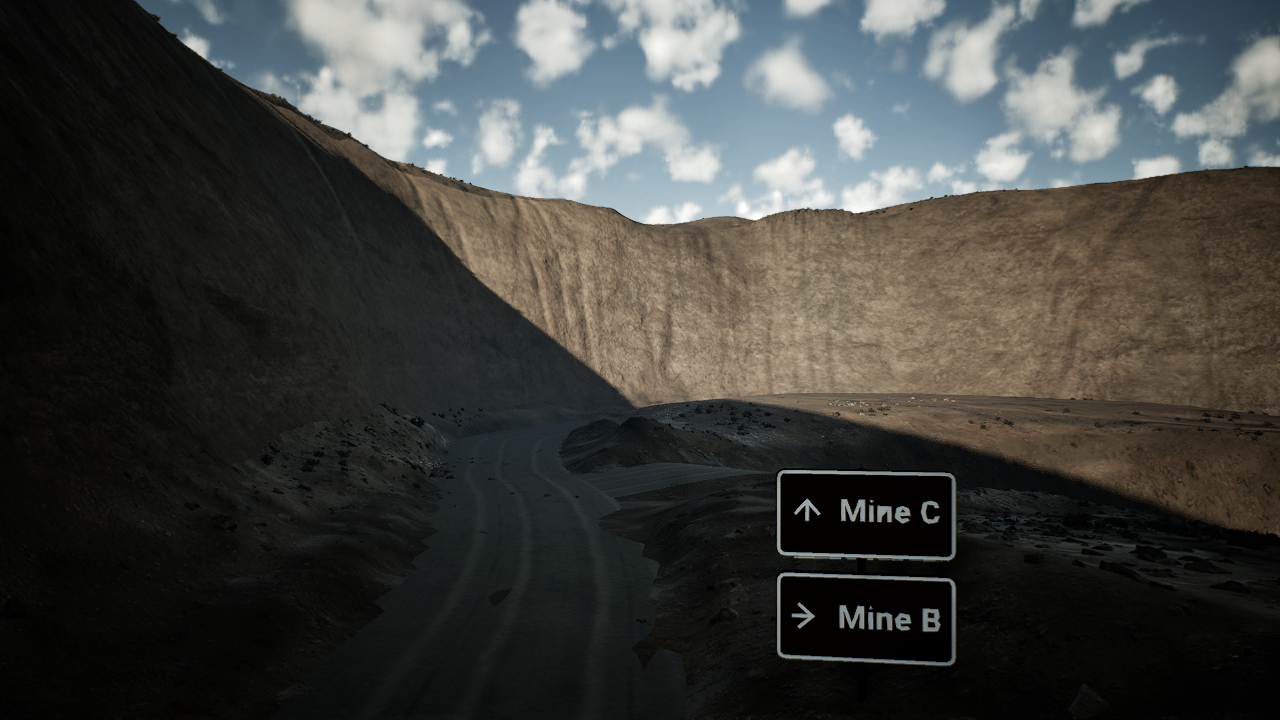

VLAM thinking...
VLAM output: {'direction': 'right', 'goal_reached': False, 'reasononing': 'The sign indicates that Mine B is to the right.'} 



KeyError: 'destination_reached'

In [3]:
from IPython.display import display
from vlm_drive.simulation.vehicle import Vehicle
from vlm_drive.simulation.waypoint_handler import WaypointHandler
from vlm_drive.model.vlam import VisionLanguageActionModel

wp_handler = WaypointHandler(start_waypoint="second_sign", first_goal_waypoint="second_sign")
vehicle = Vehicle(carla_sim, wp_handler)
vlam = VisionLanguageActionModel(backend="google", temperature=0.0)

instruction = "Please drive this vehicle to Mine B."

print("Starting navigation")
while True:        
    # Drive to destination and take an image
    vehicle.drive_to_next_waypoint()
    destination_image = vehicle.get_current_frame()
    display(destination_image)
    
    destination_reached, direction_decision = vlam.consult(destination_image, instruction)

    if not destination_reached:
        wp_handler.update_next_wp_from_direction(direction_decision)
    else:
        print("Destination reached!")
        break
    

In [44]:
vehicle.destroy()

In [27]:
carla_sim.client.reload_world()